In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import cdist
from sklearn.inspection import permutation_importance

## Load data

In [2]:
housing = fetch_california_housing(as_frame=True)

df = housing.frame


## Data Preprocessing

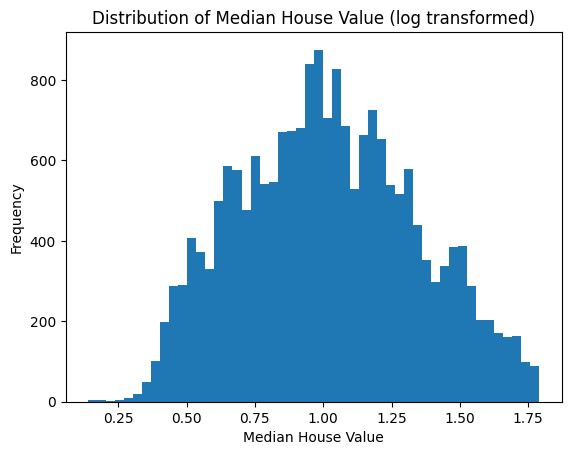

In [3]:
# Remove confusing values that are capped at 5
df = df[df['MedHouseVal'] < 5.0].copy()

# log transform
df['MedHouseVal'] = np.log1p(df['MedHouseVal'])

# plot the distribution of the log-transformed median house value
plt.figure()
plt.hist(df["MedHouseVal"], bins=50)
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.title("Distribution of Median House Value (log transformed)")
plt.show()

Add a feature for proximity to the coastline by finding boundary points

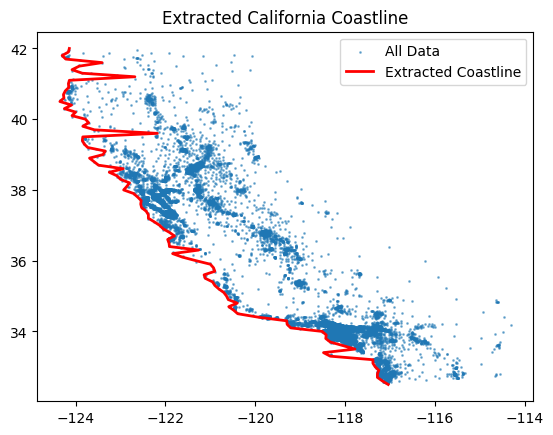

In [4]:
# Group by Latitude and find the minimum Longitude (the west-most point)
df['lat_bin'] = df['Latitude'].round(1) # round to 1 decimal place to group similar latitudes
coastline_points = df.groupby('lat_bin')['Longitude'].min().reset_index()

# Sort by Latitude to ensure the line connects in order
coastline_points = coastline_points.sort_values(by='lat_bin')

# Visualize the extracted coastline
plt.figure()
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.5, label='All Data', s=1)
plt.plot(coastline_points['Longitude'], coastline_points['lat_bin'], color='red', linewidth=2, label='Extracted Coastline')
plt.title("Extracted California Coastline")
plt.legend()
plt.show()


Calculate the distance from every house to every point on the coast 

and add this as a new feature to the dataset.

In [5]:
# Convert data into NumPy arrays for high-speed calculation
coast_coords = coastline_points[['lat_bin', 'Longitude']].values
house_coords = df[['Latitude', 'Longitude']].values

# Create distance matrix: Calculate the distance from every house to every point on the coast
distances = cdist(house_coords, coast_coords, metric='euclidean')

# Find the minimum distance for each house (the distance to the nearest point)
df['coastline_proximity'] = np.min(distances, axis=1)

# drop "lat_bin" column to remove Collinear
df = df.drop(columns=['lat_bin'])

df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,coastline_proximity
count,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000,19648.000000
mean,3.676411,28.373066,5.361708,1.096621,1441.368485,3.096560,35.651872,-119.562378,1.019006,0.525206
std,1.570602,12.504050,2.293321,0.452136,1144.075196,10.639195,2.150066,2.005760,0.323407,0.501347
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.139753,0.000000
25%,2.526300,18.000000,4.416667,1.005882,796.000000,2.446614,33.930000,-121.760000,0.772305,0.178885
50%,3.449050,28.000000,5.185730,1.048576,1179.000000,2.837779,34.270000,-118.500000,1.006497,0.318277
75%,4.582500,37.000000,5.971083,1.099222,1746.250000,3.306021,37.730000,-117.990000,1.246745,0.706045
max,15.000100,52.000000,132.533333,34.066667,35682.000000,1243.333333,41.950000,-114.310000,1.790258,3.231254


## Models with StandardScaler and Polynomial Features

In [6]:
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Ridge Regression (alpha = 10)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),

    "Polynomial Linear Regression": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "Polynomial Ridge Regression (alpha = 0.1)": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=0.1))
    ]),


    "Polynomial Ridge Regression (alpha = 1)": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),

    "Polynomial Ridge Regression (alpha = 10)": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=10.0))
    ])
}


## Train & evaluate models

In [7]:
def trainModel(models, df):
    # Split data into features and target
    X = df.drop("MedHouseVal", axis=1)
    y = df["MedHouseVal"]

    # Train / Test split (80 / 20)
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train models
    results = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append([name, rmse, mae, r2])

    results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"]).sort_values("R2", ascending=False)
    return results_df, x_test, y_test

results_df, X_test, y_test = trainModel(models, df)

results_df


,Model,RMSE,MAE,R2
2,Polynomial Linear Regression,0.179104,0.132785,0.696720
4,Polynomial Ridge Regression (alpha = 1),0.181156,0.133924,0.689728
3,Polynomial Ridge Regression (alpha = 0.1),0.181216,0.132962,0.689525
5,Polynomial Ridge Regression (alpha = 10),0.181797,0.136631,0.687531
0,Linear Regression,0.202103,0.155254,0.613826
1,Ridge Regression (alpha = 10),0.202106,0.155259,0.613818


- Polynomial Linear Regression is the best model with R2 score of 0.696720.

## Select the Best Model and "Predicted vs Actual" and "Residual" Plot

In [8]:
best_model_name = results_df.sort_values("R2", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

best_model_name


'Polynomial Linear Regression'

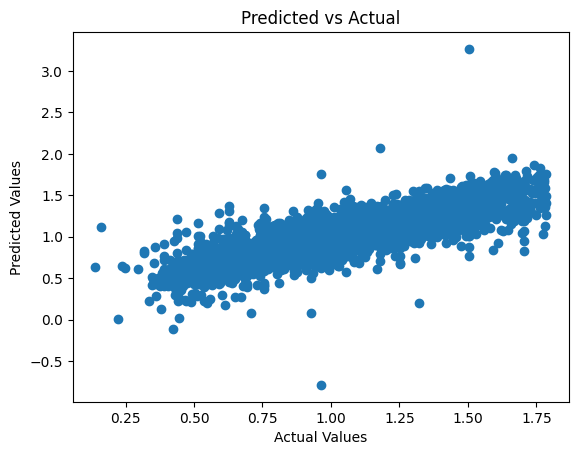

In [9]:
y_pred_best = best_model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred_best)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")
plt.show()


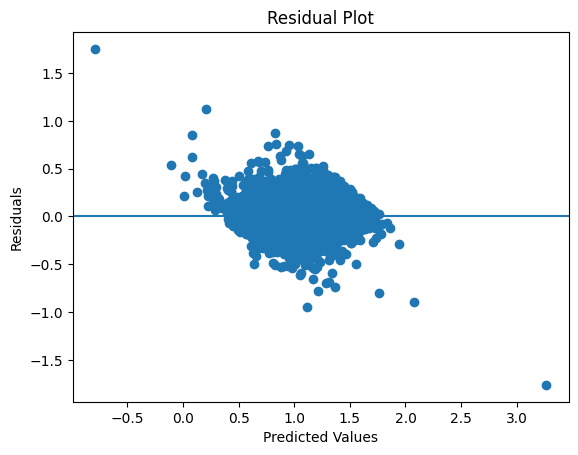

In [10]:
residuals = y_test - y_pred_best

plt.figure()
plt.scatter(y_pred_best, residuals)
plt.axhline(0)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


## Feature Importance 
Permutation Importance for Polynomial Regression

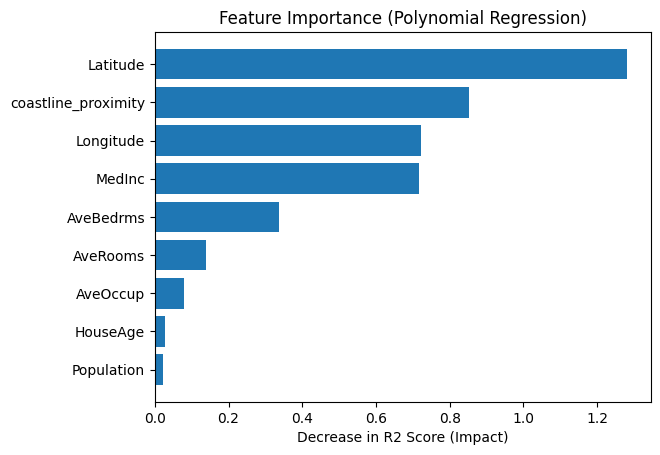

In [11]:
permutation = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
# n_repeats=10 means it shuffles each feature 10 times to get a stable average
sorted_idx = permutation.importances_mean.argsort()

plt.figure()
plt.barh(X_test.columns[sorted_idx], permutation.importances_mean[sorted_idx])
plt.title("Feature Importance (Polynomial Regression)")
plt.xlabel("Decrease in R2 Score (Impact)")
plt.show()

## Feature Importance Analysis
- Permutation Importance is used to measure the importance of each feature in the polynomial regression model.
- It is required since single feature is splited into multiple terms, such as "MedInc" and "MedInc"^2.
- Permutation Importance measures the decrease in R2 score when changing in each feature.
- Latitude is the most important feature. 
- The custom feature "coastline_proximyty" is proved highly valuable.

## Error Analysis
- Two outliers are found in the plots, but most of the data is well concentrated.

## Interpretation of results

The best trained model is Polynomial Linear Regression with metrics of RMSE = 0.179104, MAE = 0.132785, R2 Score = 0.696720.

This model is resulted much better than Linear Regression and Ridge Regression because it captured the non-linear relationship between the features and the target variable by using polynomial features.

Removing the confusing values in the data also improved the model's performance overall compare to the in-class works.

## Recommendations

- Try other models that can capture non-linear relationships between features and target variable better than Polynomial Linear Regression.
- Try to remove the outliers in the data.
- Collect the data without cap if possible to get more accurate results.